LYMPHOMA CLASSIFICATION PROJECT

---



Importing Necessary Libraries

In [14]:
import itertools
import os
import shutil
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix


Functions for automating the pre-processing tasks

In [2]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path+"/"+"train")

    train_datagen = ImageDataGenerator()

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path+"/"+"train",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    valid_datagen = ImageDataGenerator()
    validation_generator = valid_datagen.flow_from_directory(
        base_path+"/"+"val",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',shuffle=False)
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(
        base_path+"/"+"test",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', shuffle=False)
    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break

    return noOfClasses,class_names, train_generator, validation_generator,test_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

VGG-19 Model Creation

In [4]:
def initiateVGG19(noOfClasses):
    modelInput = tf.keras.applications.VGG19(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )

    for layer in modelInput.layers:
        layer.trainable = False

    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

DenseNet201 Model Creation

In [5]:
def initiateDenseNet201(noOfClasses):
    modelInput = tf.keras.applications.DenseNet201(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )

    for layer in modelInput.layers:
        layer.trainable = False

    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

MobileNet Model Creation

In [6]:
def initiateMobileNetV3(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )

    for layer in modelInput.layers:
        layer.trainable = False

    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

In [7]:
def initiateParams(className, model, lr,model_name):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + model_name+'.h5', verbose=1, save_best_only=True)

    return model, annealer, checkpoint

Function for fitting the model

In [8]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )

    return history

Function for plotting the evaluation metrics

In [9]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

Function for evaluating and saving the model

In [10]:
def evalModel(model):
    evl = model.evaluate(test_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc

def saveModel(model, className,model_name):
    model.save(className + " - "+model_name+"Final.h5")
    print("Model Saved!")

Function for plotting the confusion matrix

In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [12]:
from sklearn.metrics import recall_score,precision_score,f1_score
def callPlot(model, className, classes):
    y_true = test_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    acc=np.trace(conf_mat) / float(np.sum(conf_mat))
    print(f"ACCURACY={acc}")
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')

    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")
    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [15]:
#Open and read the JSON file
with open('kaggle (1).json', 'r') as json_file:
    data = json.load(json_file)

#Access specific values from the loaded JSON data
username = data['username']
key= data['key']

In [16]:
os.environ['KAGGLE_USERNAME'] =username
os.environ['KAGGLE_KEY'] =key

In [42]:
!kaggle datasets download -d mdrabbaniuvce/multi-cancer

100% 8.59G/8.62G [01:58<00:00, 113MB/s]
100% 8.62G/8.62G [01:58<00:00, 77.9MB/s]


In [43]:
!unzip multi-cancer.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0001.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0002.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0003.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0006.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0007.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0008.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0009.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0011.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0013.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0015.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0016.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0017.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0019.jpg  
  inflating: Dataset/Oral Cancer/train/oral_scc/oral_scc_0020.jpg

In [44]:
mpath = r'Dataset'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
lr = 0.001

In [45]:
import pprint
part={}
for c in classPaths:
#     part[c]={'models':{"EfficientNetB7":{"model":None,"accurary":0},
#                     "Densenet201":{"model":None,"accurary":0},
#                     "VGG19":{"model":None,"accurary":0},
#                     "ResnetV2":{"model":None,"accurary":0},
#                     "mobilenetV3":{"model":None,"accurary":0}
#                    },'no_of_classes':0,"ClassNames":None}
    part[c]={'models':{},'no_of_classes':0,"ClassNames":None}

In [46]:
pprint.pprint(part)

{'ALL': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Brain Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Breast Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Cervical Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Kidney Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Lung and Colon Cancer': {'ClassNames': None,
                           'models': {},
                           'no_of_classes': 0},
 'Lymphoma': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Oral Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0}}


Function for ensembling the models

In [23]:
def Ensemble(c):
    y_true = test_generator.classes
    print("True : ", (y_true))
    pred=[]
    for model,obj in part[c]['models'].items():
        pred.append(obj['model'].predict(test_generator)*obj['Accurary'])
    y_pred=pred[0]
    for i in range(1,len(pred)):
        y_pred=y_pred+pred[i]

    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    acc=np.trace(conf_mat) / float(np.sum(conf_mat))
    print(f"ACCURACY={acc}")
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = part[c]['ClassNames'],
                          title        = c + "Confusion Matrix")

In [24]:
def initiateResNet50V2(noOfClasses):
    modelInput = tf.keras.applications.ResNet50V2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )

    for layer in modelInput.layers:
        layer.trainable = False

    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


Total :  Found 10500 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
######################################################
RESULTS FORVGG-19
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 5.7979 - accuracy: 0.6455
Epoch 1: val_loss improved from inf to 6.93069, saving model to LymphomaVGG-19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - 86s 219ms/step - loss: 5.7979 - accuracy: 0.6455 - val_loss: 6.9307 - val_accuracy: 0.6671 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 2.3374 - accuracy: 0.8252
Epoch 2: val_loss improved from 6.93069 to 3.82335, saving model to LymphomaVGG-19.h5
329/329 [==============================] - 64s 195ms/step - loss: 2.3374 - accuracy: 0.8252 - val_loss: 3.8233 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 1.7540 - accuracy: 0.8684
Epoch 3: val_loss did not improve from 3.82335
329/329 [==============================] - 64s 194ms/step - loss: 1.7540 - accuracy: 0.8684 - val_loss: 5.6186 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 4/10
329/329 [==============================] - ETA: 0s - loss: 1.2464 - accuracy: 0.9069
Epoch 4: val_loss improved from 3.82335 to 2.93973, saving model to LymphomaVGG-19.h5
329/329 [==============================] - 65s 197ms

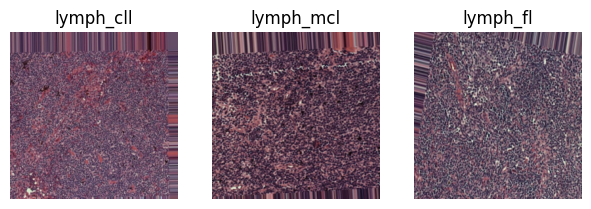

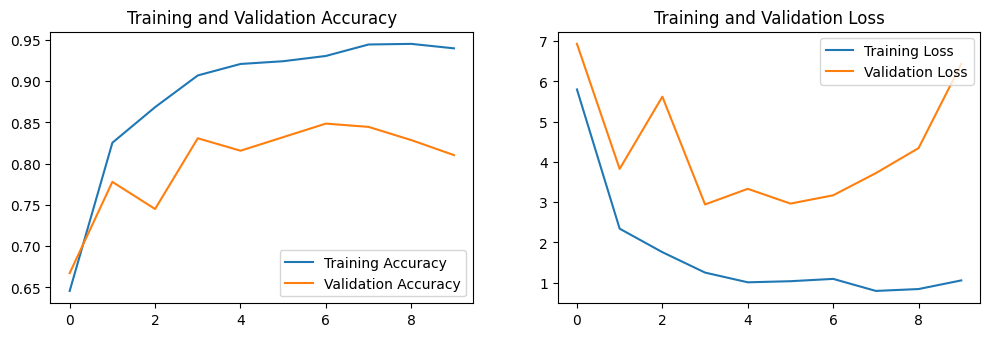

71/71 [==============================] - 12s 163ms/step - loss: 6.0343 - accuracy: 0.8271
Accuracy on the Test Set = 82.71 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
71/71 [==============================] - 12s 164ms/step
Predicted :  [1 0 0 ... 1 0 2]
ACCURACY=0.8271111111111111
RECALL=0.8271111111111111
precision=0.8402669254277573
F1 Score0.8216452141338935


<Figure size 640x480 with 0 Axes>

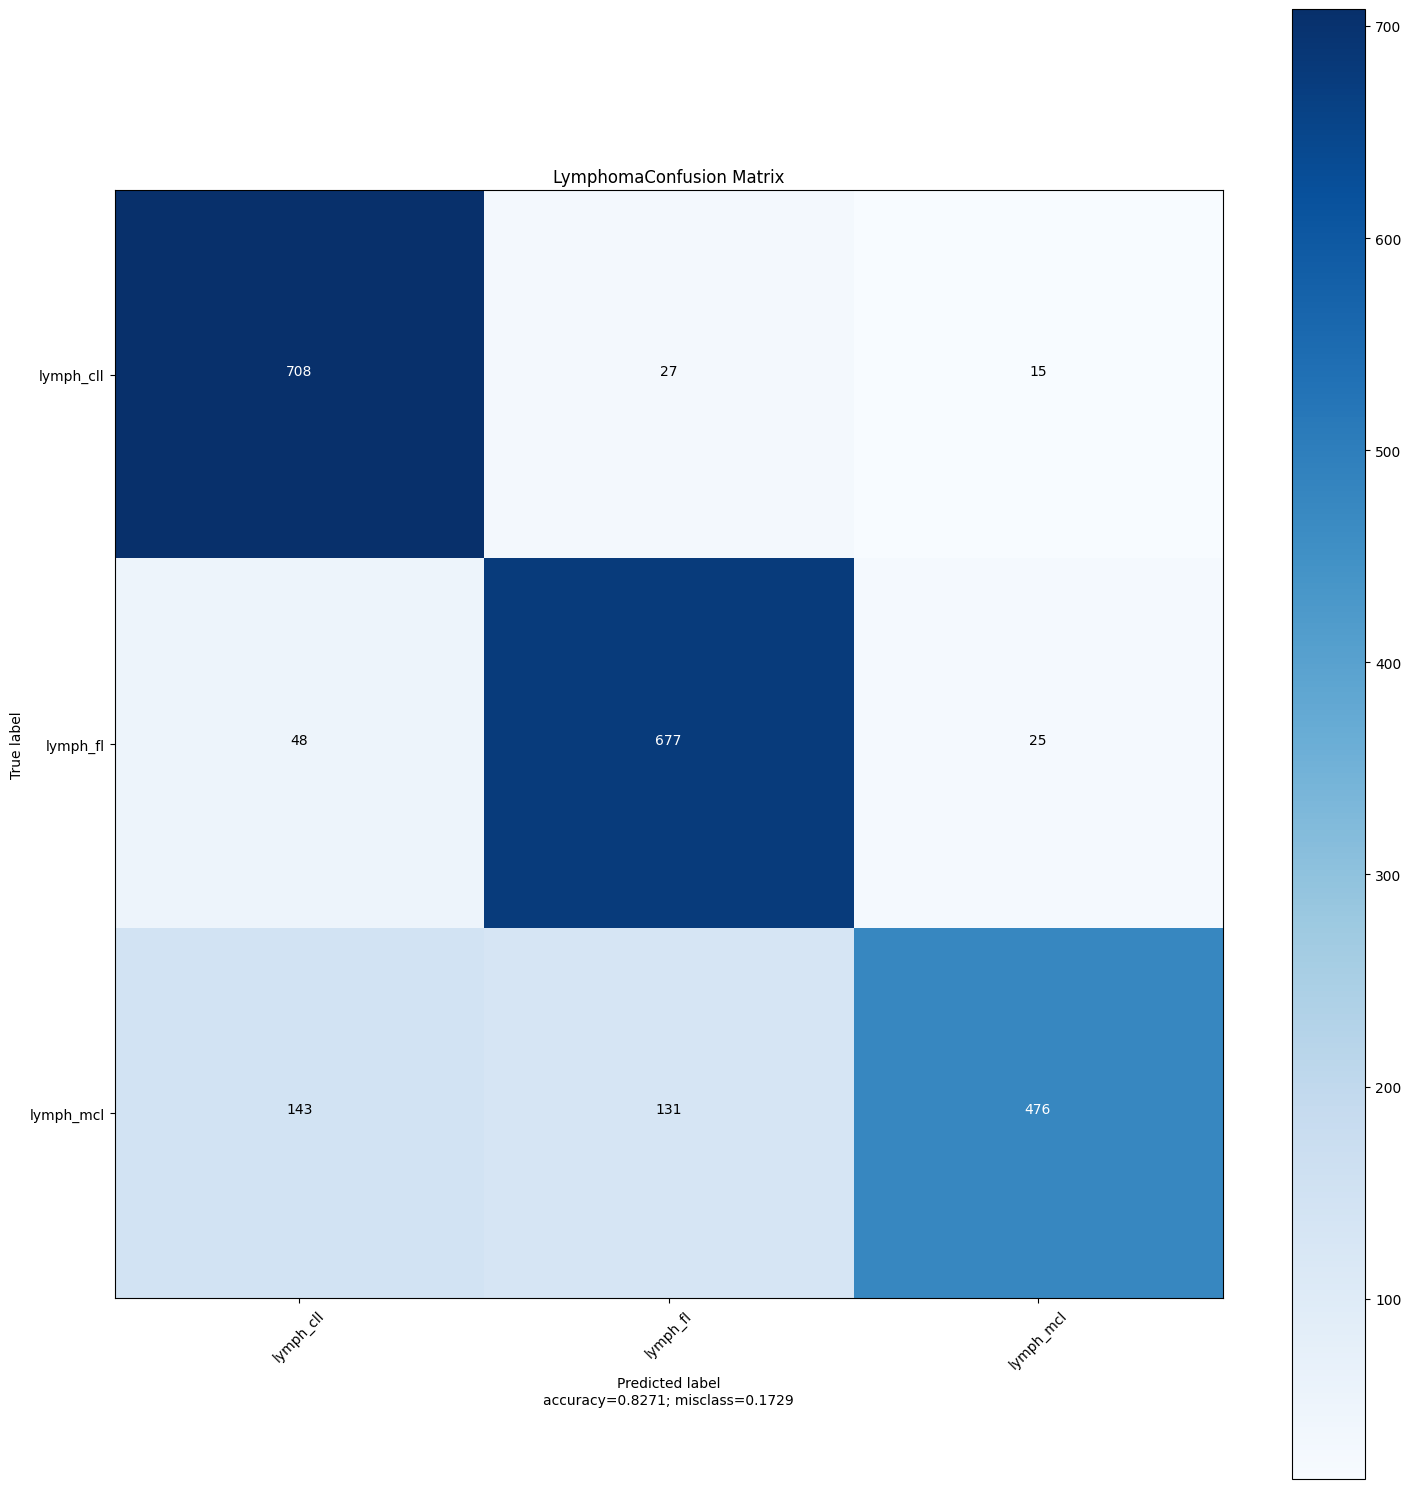

######################################################
RESULTS FORDenseNet201
74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 4.1482 - accuracy: 0.7878
Epoch 1: val_loss improved from inf to 1.26938, saving model to LymphomaDenseNet201.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - 87s 222ms/step - loss: 4.1482 - accuracy: 0.7878 - val_loss: 1.2694 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.9270 - accuracy: 0.9232
Epoch 2: val_loss improved from 1.26938 to 0.85506, saving model to LymphomaDenseNet201.h5
329/329 [==============================] - 64s 195ms/step - loss: 0.9270 - accuracy: 0.9232 - val_loss: 0.8551 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 1.3337 - accuracy: 0.9177
Epoch 3: val_loss did not improve from 0.85506
329/329 [==============================] - 63s 190ms/step - loss: 1.3337 - accuracy: 0.9177 - val_loss: 1.3963 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 4/10
329/329 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.9586
Epoch 4: val_loss improved from 0.85506 to 0.64302, saving model to LymphomaDenseNet201.h5
329/329 [==============================] -

<Figure size 640x480 with 0 Axes>

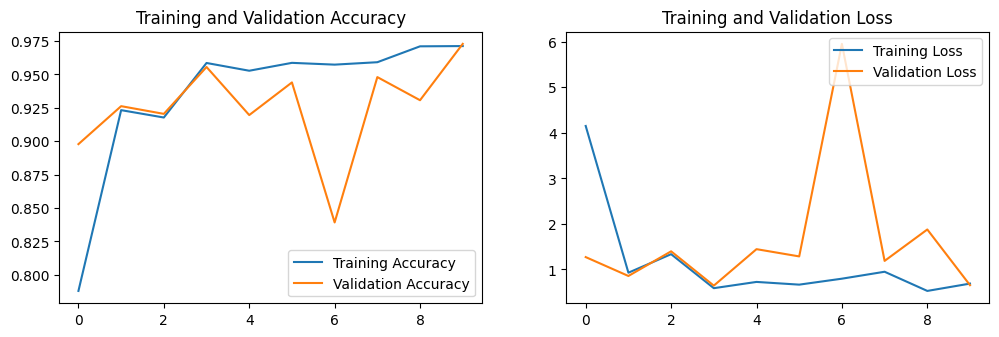

71/71 [==============================] - 11s 156ms/step - loss: 0.6105 - accuracy: 0.9724
Accuracy on the Test Set = 97.24 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
71/71 [==============================] - 15s 164ms/step
Predicted :  [0 0 0 ... 2 2 1]
ACCURACY=0.9724444444444444
RECALL=0.9724444444444444
precision=0.9725291395027235
F1 Score0.9724559614117847


<Figure size 640x480 with 0 Axes>

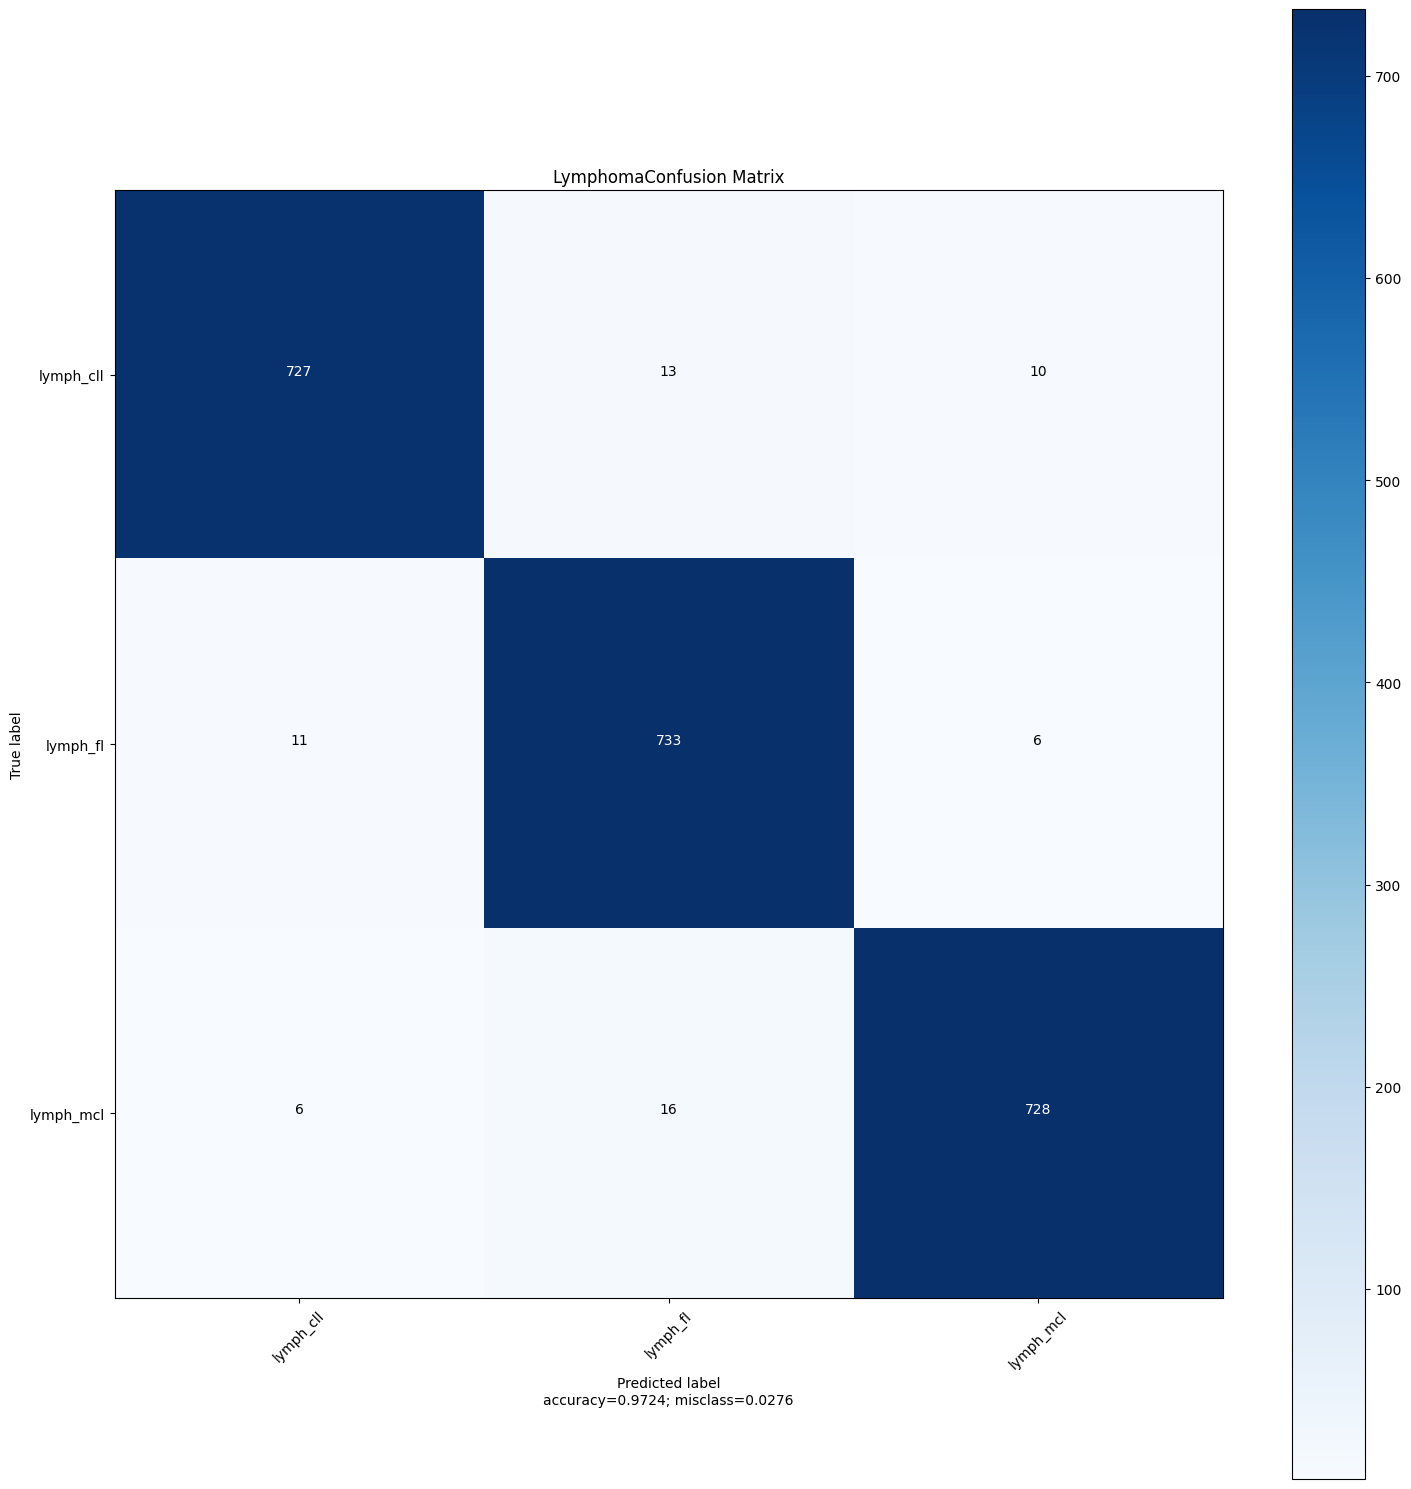

######################################################
RESULTS FORMobileNetV3
4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 1.3779 - accuracy: 0.6862
Epoch 1: val_loss improved from inf to 0.93629, saving model to LymphomaMobileNetV3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - 55s 154ms/step - loss: 1.3779 - accuracy: 0.6862 - val_loss: 0.9363 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.4667 - accuracy: 0.8699
Epoch 2: val_loss did not improve from 0.93629
329/329 [==============================] - 46s 141ms/step - loss: 0.4667 - accuracy: 0.8699 - val_loss: 1.0008 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.2468 - accuracy: 0.9225
Epoch 3: val_loss improved from 0.93629 to 0.84208, saving model to LymphomaMobileNetV3.h5
329/329 [==============================] - 51s 154ms/step - loss: 0.2468 - accuracy: 0.9225 - val_loss: 0.8421 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 4/10
329/329 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9546
Epoch 4: val_loss improved from 0.84208 to 0.82660, saving model to LymphomaMobileNetV3.h5
329/329 [==============================] -

<Figure size 640x480 with 0 Axes>

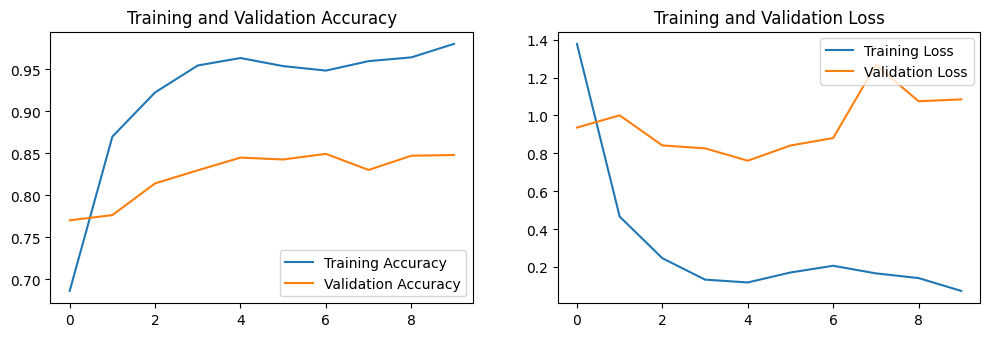

71/71 [==============================] - 8s 110ms/step - loss: 1.0662 - accuracy: 0.8507
Accuracy on the Test Set = 85.07 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
71/71 [==============================] - 9s 107ms/step
Predicted :  [0 0 0 ... 2 2 2]
ACCURACY=0.8506666666666667
RECALL=0.8506666666666667
precision=0.8549538412517318
F1 Score0.8515844452347069


<Figure size 640x480 with 0 Axes>

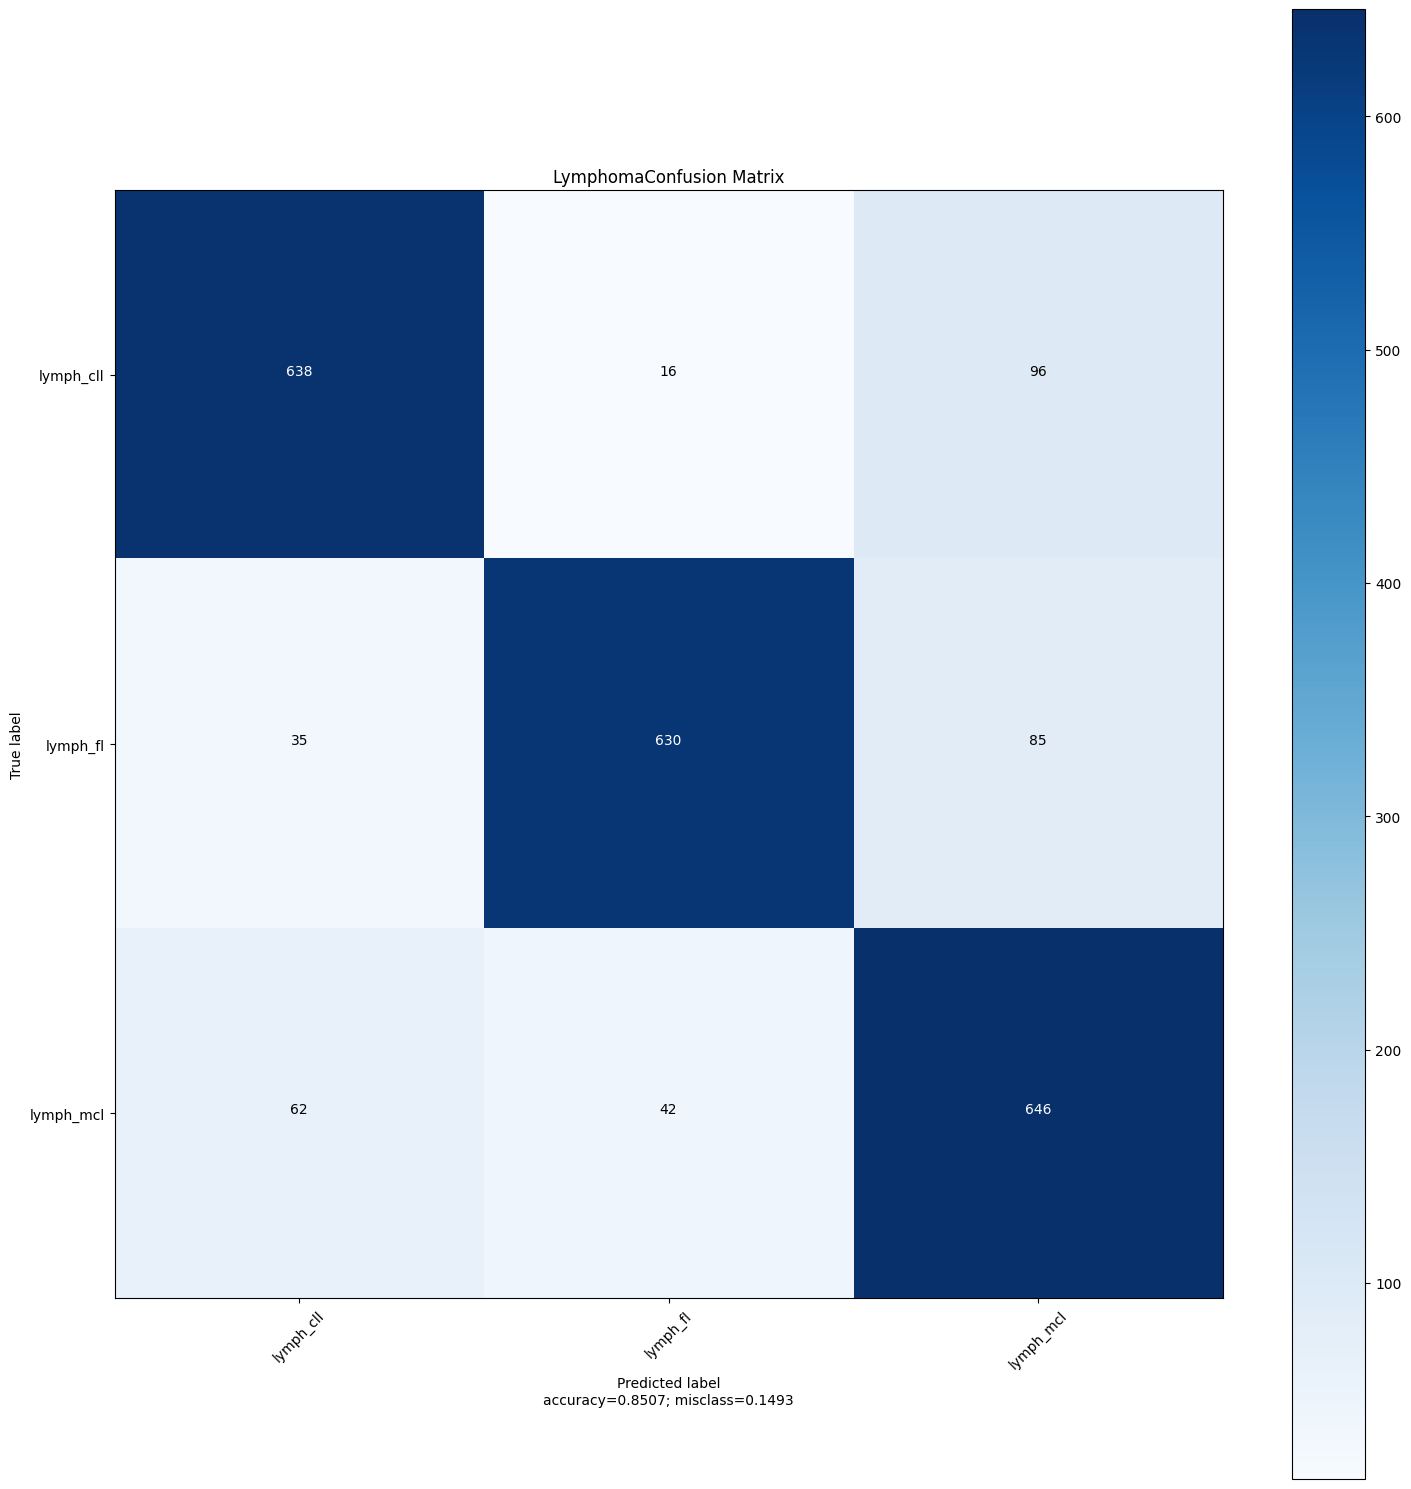

######################################################
RESULTS FORResNet50V2
94668760/94668760 [==============================] - 0s 0us/step
Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 153.9006 - accuracy: 0.5770
Epoch 1: val_loss improved from inf to 204.01280, saving model to LymphomaResNet50V2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - 61s 170ms/step - loss: 153.9006 - accuracy: 0.5770 - val_loss: 204.0128 - val_accuracy: 0.4413 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 76.3418 - accuracy: 0.6700
Epoch 2: val_loss improved from 204.01280 to 44.02006, saving model to LymphomaResNet50V2.h5
329/329 [==============================] - 55s 167ms/step - loss: 76.3418 - accuracy: 0.6700 - val_loss: 44.0201 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 77.1559 - accuracy: 0.6945
Epoch 3: val_loss did not improve from 44.02006
329/329 [==============================] - 55s 166ms/step - loss: 77.1559 - accuracy: 0.6945 - val_loss: 176.2112 - val_accuracy: 0.5053 - lr: 0.0010
Epoch 4/10
329/329 [==============================] - ETA: 0s - loss: 52.6350 - accuracy: 0.7609
Epoch 4: val_loss improved from 44.02006 to 32.62473, saving model to LymphomaResNet50V2.h5
329/329 [=================

<Figure size 640x480 with 0 Axes>

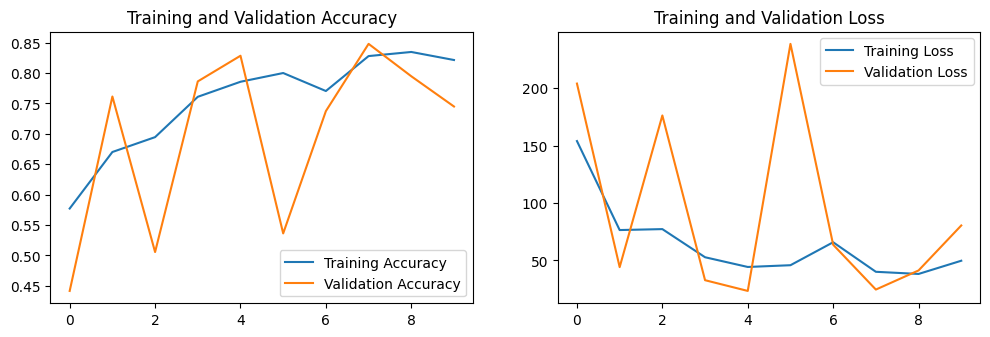

71/71 [==============================] - 10s 141ms/step - loss: 76.2918 - accuracy: 0.7551
Accuracy on the Test Set = 75.51 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
71/71 [==============================] - 11s 138ms/step
Predicted :  [0 0 0 ... 2 2 2]
ACCURACY=0.7551111111111111
RECALL=0.7551111111111111
precision=0.8199867541725899
F1 Score0.7422611167271415


<Figure size 640x480 with 0 Axes>

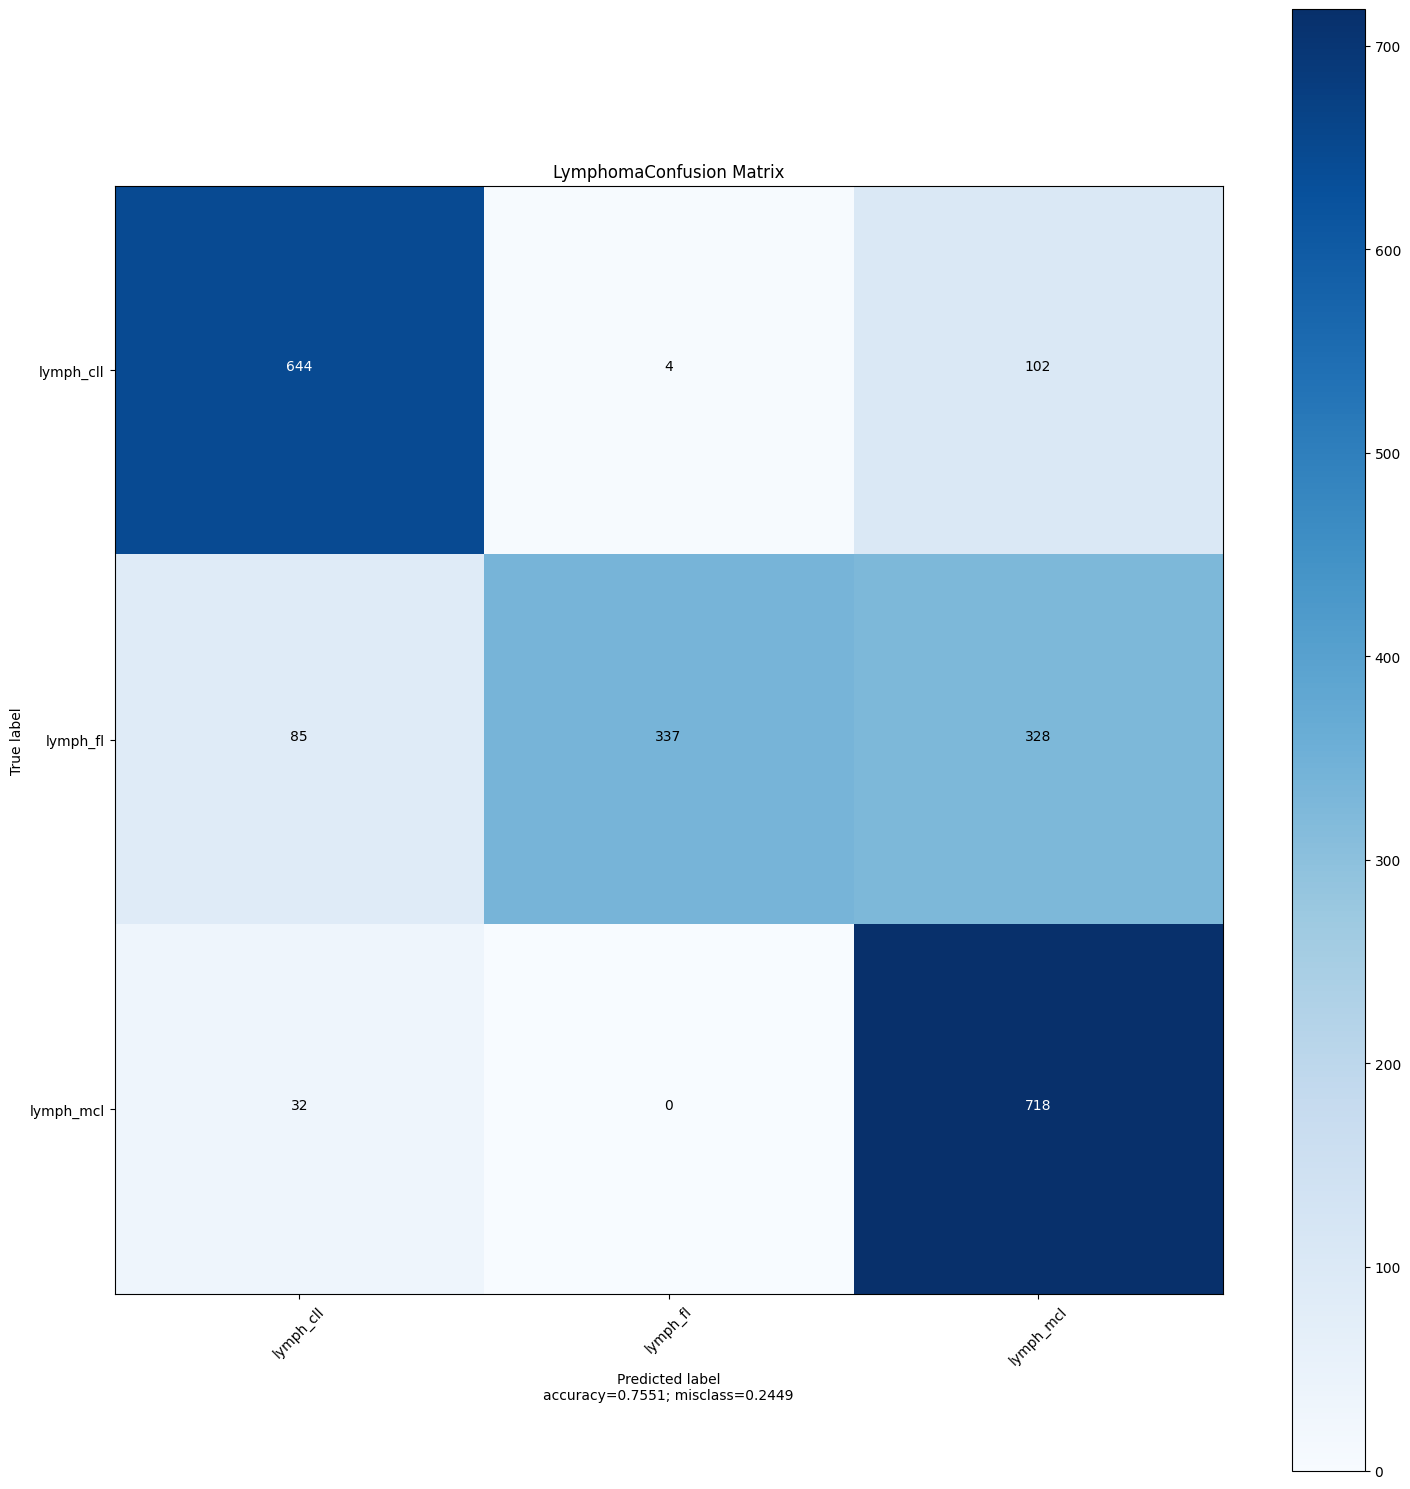

######################################################
RESULTS FOR ENSEMBLE
True :  [0 0 0 ... 2 2 2]
71/71 [==============================] - 10s 139ms/step
Predicted :  [0 0 0 ... 2 2 2]
ACCURACY=0.98
RECALL=0.98
precision=0.9802634028116006
F1 Score0.9799926754954187


<Figure size 640x480 with 0 Axes>

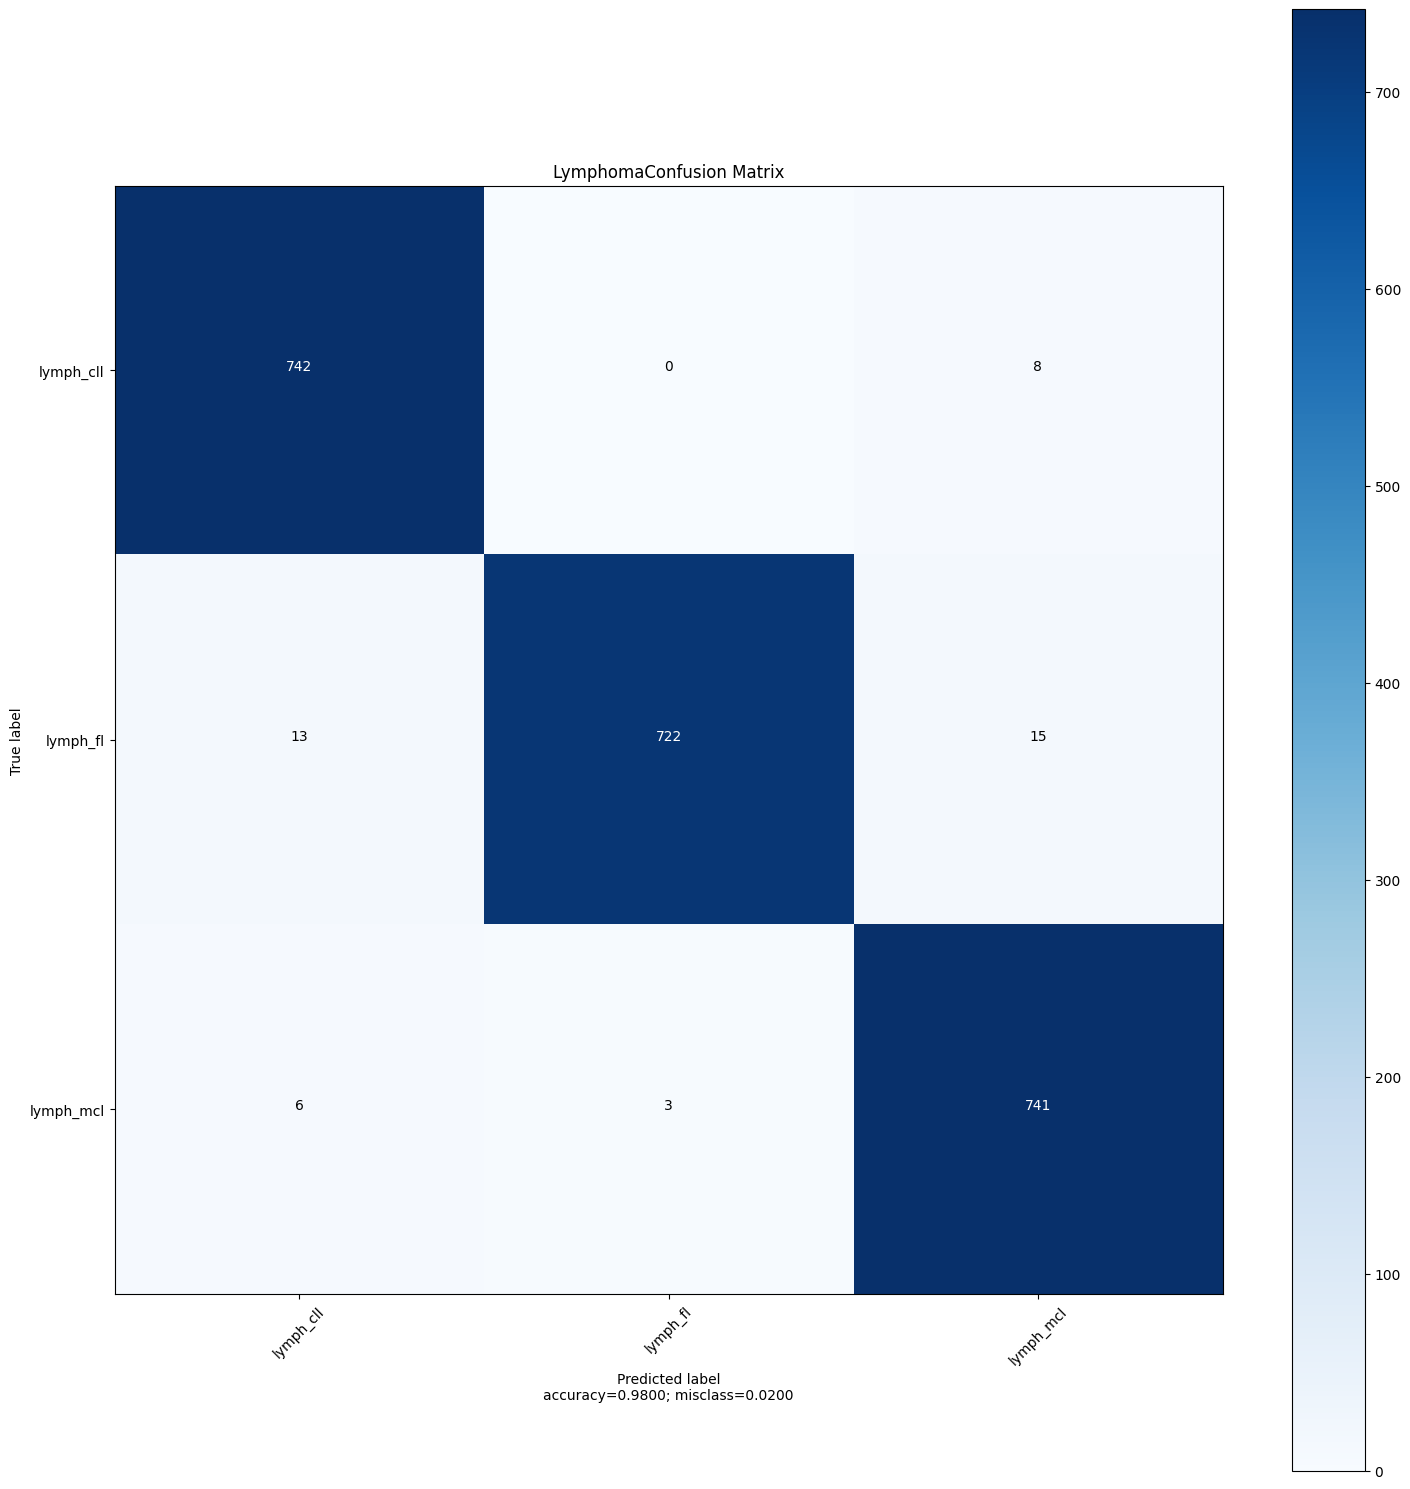

<Figure size 640x480 with 0 Axes>

In [49]:
for c in classPaths[1:2]:
    className = c
#     model_name="VGG-19"
    cpath = os.path.join(mpath, c)
    noOfClasses, class_names, train_generator, validation_generator,test_generator = initiateGenerator(cpath)
    part[c]['ClassNames']=class_names



    model_name="VGG-19"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curVGG19 = initiateVGG19(noOfClasses)
    #modelSummary(curVGG19)
    curVGG19, annealer, checkpoint = initiateParams(className, curVGG19, lr,model_name)
    curHistory = modelFit(curVGG19, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curVGG19)

    saveModel(curVGG19, className,model_name)
    part[c]['models']['VGG19']={"model":curVGG19,'Accurary':acc}
    callPlot(curVGG19, className, class_names)

    model_name="DenseNet201"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curDenseNet201= initiateDenseNet201(noOfClasses)
    #modelSummary(curDenseNet201)
    curDenseNet201, annealer, checkpoint = initiateParams(className, curDenseNet201, lr,model_name)
    curHistory = modelFit(curDenseNet201, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curDenseNet201)
    saveModel(curDenseNet201, className,model_name)
    part[c]['models']['DenseNet201']={"model":curDenseNet201,'Accurary':acc}
    callPlot(curDenseNet201, className, class_names)



    model_name="MobileNetV3"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curMobileNetV3 = initiateMobileNetV3(noOfClasses)
    #modelSummary(curMobileNetV3)
    curMobileNetV3, annealer, checkpoint = initiateParams(className, curMobileNetV3, lr,model_name)
    curHistory = modelFit(curMobileNetV3, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curMobileNetV3)
    saveModel(curMobileNetV3, className,model_name)
    part[c]['models']['MobileNetV3']={"model":curMobileNetV3,'Accurary':acc}
    callPlot(curMobileNetV3, className, class_names)

    model_name="ResNet50V2"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curResNet50V2 = initiateResNet50V2(noOfClasses)
    #modelSummary(curResNet50V2)
    curResNet50V2, annealer, checkpoint = initiateParams(className, curResNet50V2, lr,model_name)
    curHistory = modelFit(curResNet50V2, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curResNet50V2)
    saveModel(curResNet50V2, className,model_name)
    part[c]['models']['ResNet50V2']={"model":curResNet50V2,'Accurary':acc}
    callPlot(curResNet50V2, className, class_names)
    print("######################################################")
    print(f"RESULTS FOR ENSEMBLE")
    Ensemble(c)